# Construction RAG - Full Pipeline Demo

This notebook demonstrates the complete pipeline with:
- Batch processing of multiple drawings
- LLM-powered summaries
- Question answering

## Prerequisites

Set your OpenRouter API key for LLM features:
```bash
export OPENROUTER_API_KEY="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"
```

In [1]:
import os

# Force CPU mode - RTX 5060 (Blackwell/sm_120) not yet supported by PyTorch
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from construction_rag import ConstructionRAGPipeline

# Check if API key is set
api_key = os.environ.get("OPENROUTER_API_KEY")
print(f"OpenRouter API key: {'Set ✓' if api_key else 'Not set ✗'}")
print("Running in CPU mode (RTX 5060 not yet supported by PyTorch)")

OpenRouter API key: Not set ✗
Running in CPU mode (RTX 5060 not yet supported by PyTorch)


## 1. Initialize Pipeline with LLM Support

In [2]:
# Pass API key directly (or set OPENROUTER_API_KEY environment variable)
api_key = os.environ.get("OPENROUTER_API_KEY") or "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"

pipeline = ConstructionRAGPipeline(
    persist_directory="./full_pipeline_db",
    enable_summaries=True,  # Enable LLM summaries
    llm_model="openai/gpt-4o-mini",  # Fast and cost-effective
    llm_api_key=api_key,  # Pass API key directly
    cluster_eps=0.02,  # DBSCAN epsilon
    cluster_min_samples=2
)

# Clear old database to ensure fresh start with updated code
pipeline.clear()
print("Database cleared for fresh start!")

print(f"LLM enabled: {pipeline.llm is not None}")
if pipeline.llm:
    print(f"LLM model: {pipeline.llm.model}")

Database cleared for fresh start!
LLM enabled: True
LLM model: openai/gpt-4o-mini


## 2. Batch Process Multiple Drawings

In [3]:
# Get all sample images
import glob

image_paths = glob.glob("sample_images/*.jpg")
print(f"Found {len(image_paths)} sample images:")
for path in image_paths:
    print(f"  - {os.path.basename(path)}")

Found 5 sample images:
  - dataset_image_01.jpg
  - dataset_image_02.jpg
  - dataset_image_03.jpg
  - dataset_image_04.jpg
  - dataset_image_05.jpg


In [4]:
# Process all images
results = pipeline.process_batch(image_paths, verbose=True)

Processing [1/5]: dataset_image_01.jpg


[INFO] 2026-02-03 21:43:31,581 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:43:31,595 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:43:31,595 [RapidOCR] main.py:53: Using C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:43:31,648 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:43:31,648 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-02-03 21:43:31,654 [Rapid

  158 chunks, 53.7s - OK
Processing [2/5]: dataset_image_02.jpg


[INFO] 2026-02-03 21:45:05,337 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:45:05,341 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:45:05,342 [RapidOCR] main.py:53: Using C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:45:05,403 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:45:05,405 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-02-03 21:45:05,406 [Rapid

  107 chunks, 41.3s - OK
Processing [3/5]: dataset_image_03.jpg


[INFO] 2026-02-03 21:45:48,128 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:45:48,132 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:45:48,132 [RapidOCR] main.py:53: Using C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:45:48,195 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:45:48,197 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-02-03 21:45:48,198 [Rapid

  76 chunks, 42.8s - OK
Processing [4/5]: dataset_image_04.jpg


[INFO] 2026-02-03 21:46:34,428 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:46:34,433 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:46:34,433 [RapidOCR] main.py:53: Using C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-03 21:46:34,497 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-03 21:46:34,499 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\noela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-02-03 21:46:34,500 [Rapid

  174 chunks, 46.3s - OK
Processing [5/5]: dataset_image_05.jpg
  79 chunks, 44.6s - OK


## 2.1 Visualize Processing Results

Let's visualize the bounding boxes for chunks detected in the first 2 images:


dataset_image_01.jpg: 158 chunks detected


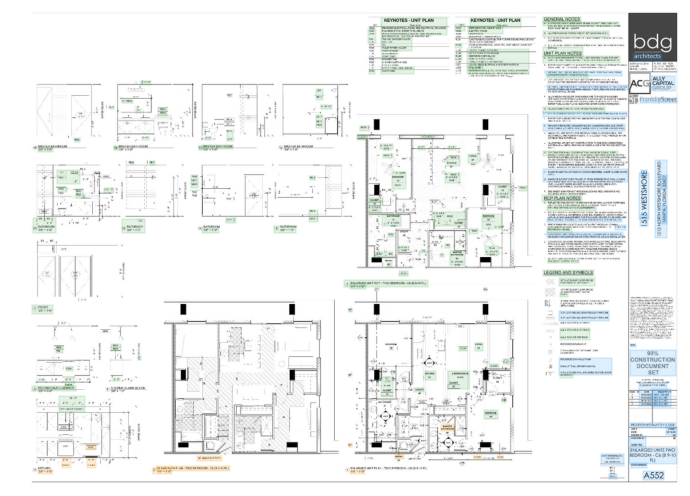


dataset_image_02.jpg: 107 chunks detected


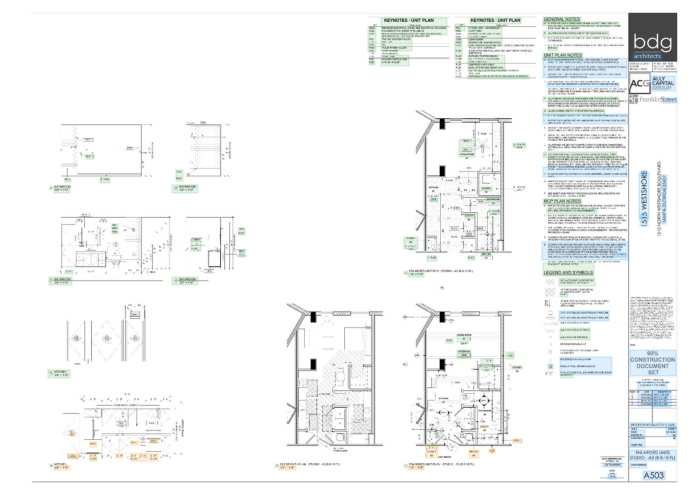

In [5]:
from construction_rag import draw_bounding_boxes
import matplotlib.pyplot as plt

# Show first 2 processed images with bounding boxes
for result in results[:2]:
    if result.success:
        print(f"\n{result.source_image}: {len(result.chunks)} chunks detected")
        fig = draw_bounding_boxes(
            f"sample_images/{os.path.basename(result.source_image)}",
            result.chunks,
            show_labels=True
        )
        plt.show()
        plt.close(fig)  # Free memory immediately

In [6]:
# Summary of processing
successful = sum(1 for r in results if r.success)
total_chunks = sum(len(r.chunks) for r in results)
total_time = sum(r.processing_time for r in results)

print(f"\nProcessing Summary:")
print(f"  Images processed: {successful}/{len(results)}")
print(f"  Total chunks: {total_chunks}")
print(f"  Total time: {total_time:.1f}s")
print(f"  Average time/image: {total_time/len(results):.1f}s")


Processing Summary:
  Images processed: 5/5
  Total chunks: 594
  Total time: 228.7s
  Average time/image: 45.7s


## 3. Examine LLM-Generated Summaries

Sample chunks with LLM summaries and cropped regions:


--- Chunk 1: [text] text_0001 ---


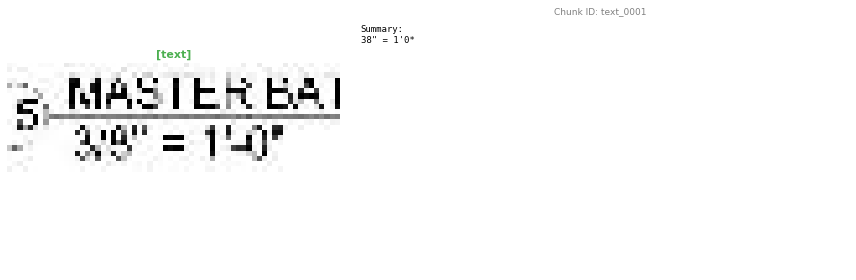


--- Chunk 2: [text] text_0002 ---


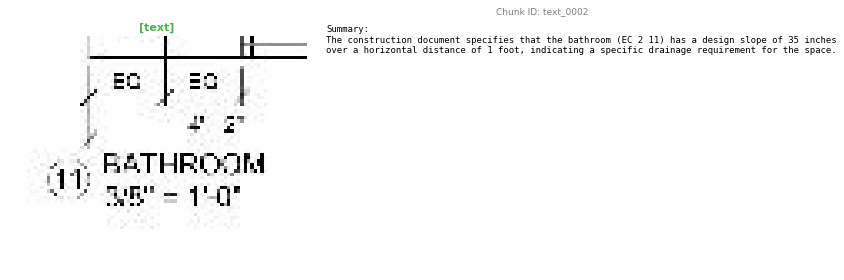


--- Chunk 3: [text] text_0003 ---


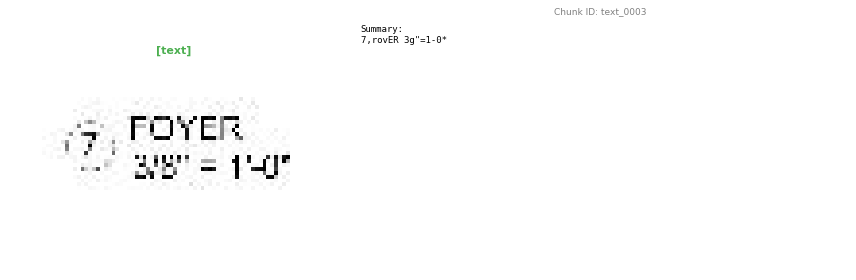


--- Chunk 4: [notes] notes_0004 ---


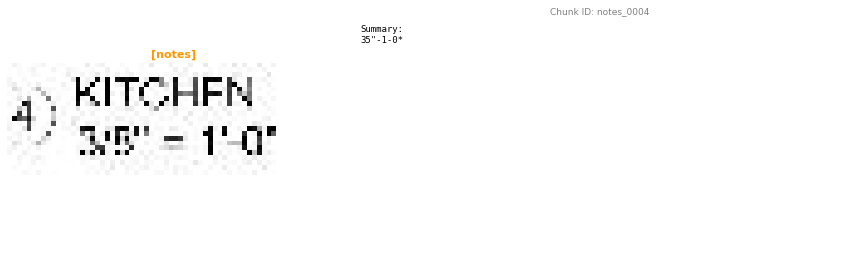


--- Chunk 5: [text] text_0005 ---


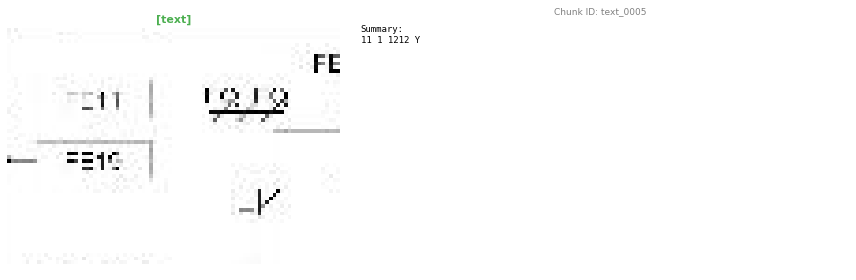

In [7]:
# Show chunks with their summaries - including cropped images of the regions
from construction_rag.visualization import display_chunk_with_summary

all_chunks = [c for r in results for c in r.chunks]

print("Sample chunks with LLM summaries and cropped regions:\n")

# Display first 5 chunks with summaries using the new visualization
for i, chunk in enumerate(all_chunks[:5]):
    print(f"\n--- Chunk {i+1}: [{chunk.chunk_type}] {chunk.chunk_id} ---")
    
    # Get source image for this chunk
    source_image = chunk.metadata.get('source_image', '')
    if source_image:
        image_path = f"sample_images/{os.path.basename(source_image)}"
        
        # Display cropped region with summary
        fig = display_chunk_with_summary(image_path, chunk)
        plt.show()
        plt.close(fig)
    else:
        print(f"  Content: {chunk.content[:100]}...")
        if chunk.summary:
            print(f"  Summary: {chunk.summary}")

## 4. Semantic Search


Query: 'door schedule fire rating'

  Result 1: [text] Score: -0.125
  Summary: The document references a 1-bedroom unit labeled A1008 B8, directing attention to specific details found on drawing 1/A24 and indicating a requirement for a Fire Code Review (FCR).


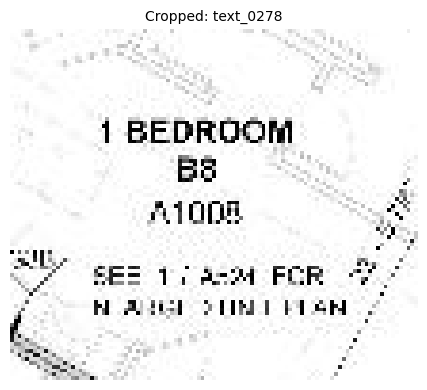


  Result 2: [text] Score: -0.411
  Summary: The document outlines the schedule and specifications for the construction of elevator systems, detailing requirements for installation and maintenance. It emphasizes compliance with safety standards and project timelines.


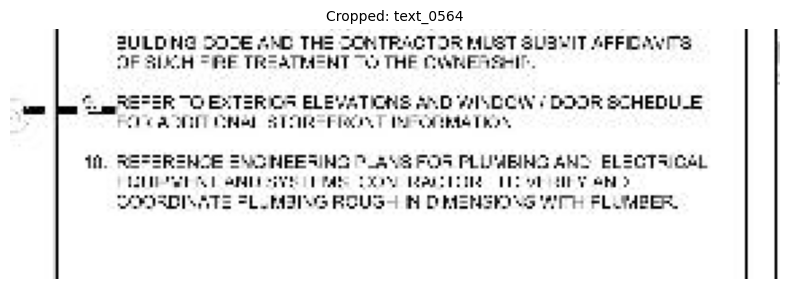


  Result 3: [title_block] Score: -0.431
  Summary: The document outlines specifications for the installation of a recessed can light and a mechanical exhaust fan, including details on the necessary electrical connections and structural requirements for the sconce door. Key information includes the type of fixtures to be used and installation guidelines to ensure compliance with safety standards.


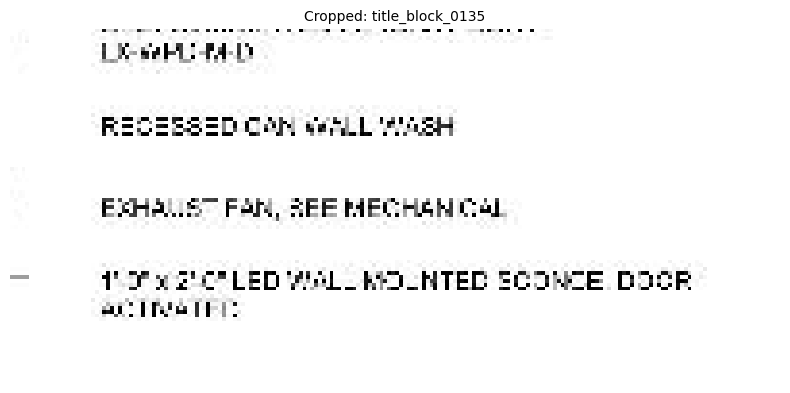


Query: 'general notes'

  Result 1: [text] Score: 1.000
  Summary: GENERAL NOTES


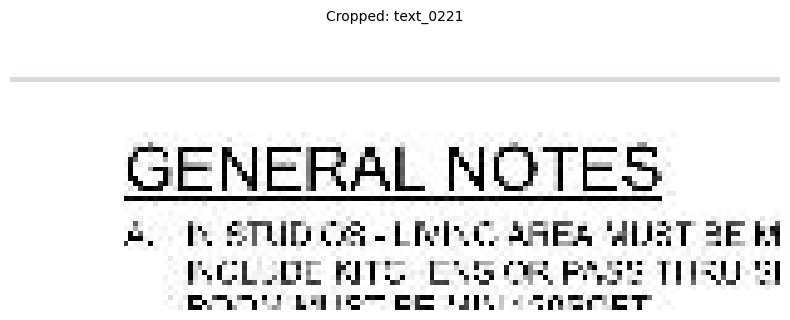


  Result 2: [text] Score: 1.000
  Summary: GENERAL NOTES


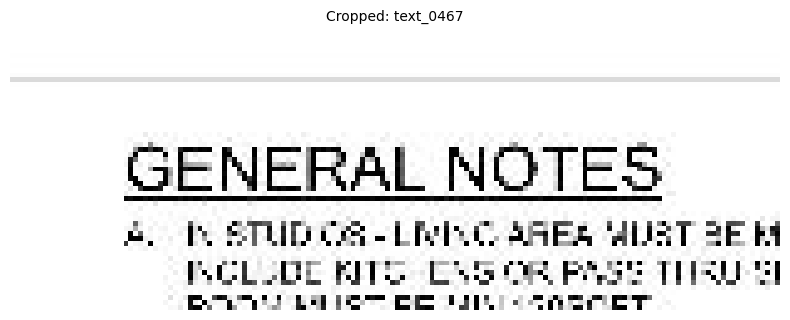


  Result 3: [text] Score: 1.000
  Summary: GENERAL NOTES


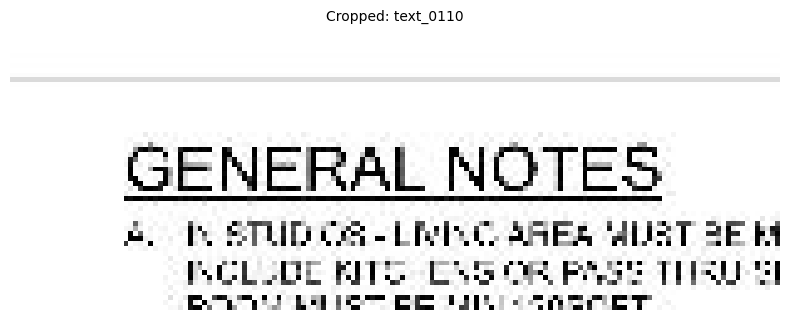


Query: 'project information'

  Result 1: [title_block] Score: 0.215
  Summary: The document outlines key project information, including specifications and requirements for the construction project, emphasizing essential details necessary for successful execution.


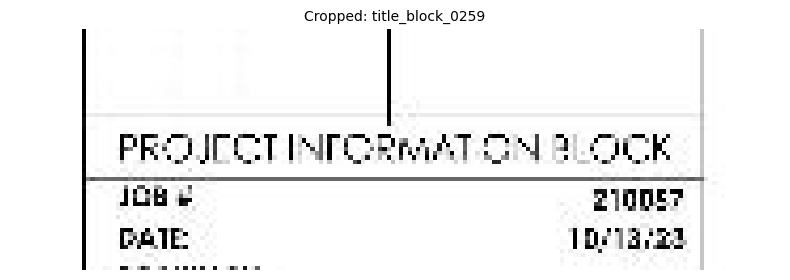


  Result 2: [title_block] Score: 0.127
  Summary: The document outlines key project information and specifications for the construction project, including essential requirements and guidelines for execution. It serves as a comprehensive reference for stakeholders involved in the project.


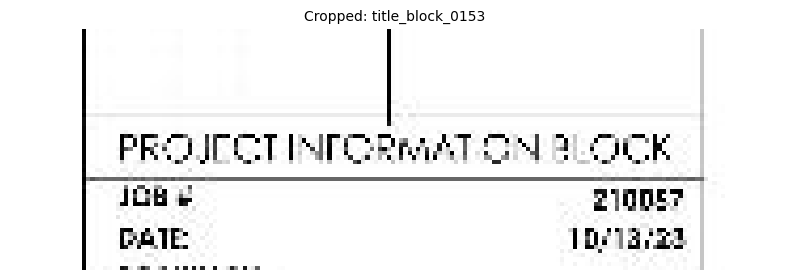


  Result 3: [title_block] Score: 0.058
  Summary: The construction document outlines essential project information, including specifications and requirements necessary for successful execution. Key details include project timelines, materials to be used, compliance standards, and specific roles and responsibilities of involved parties.


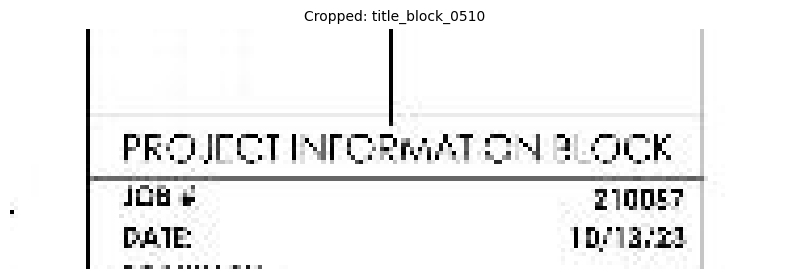


Query: 'floor plan layout'

  Result 1: [text] Score: 0.350
  Summary: The general notes for the floor plan outline essential specifications and requirements for the construction project, including dimensions, materials, and structural guidelines that must be adhered to throughout the building process. Key information includes specific measurements, placement of walls and openings, and compliance with safety and building codes.


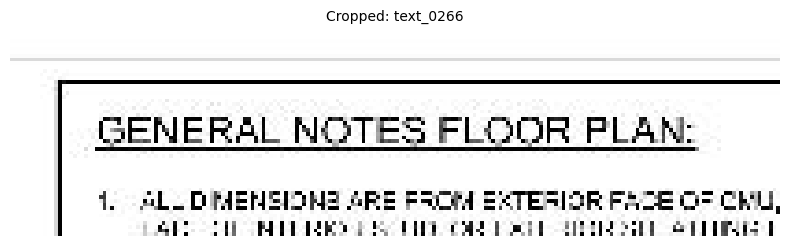


  Result 2: [text] Score: 0.295
  Summary: The general notes for the floor plan outline essential specifications and requirements for the construction project, including dimensions, materials, and installation guidelines necessary for compliance and structural integrity. Key information emphasizes adherence to safety standards and coordination with other trades involved in the project.


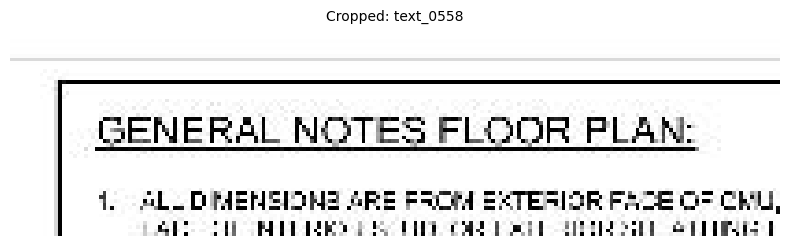


  Result 3: [text] Score: 0.252
  Summary: The document outlines keynotes related to an enlarged floorplan, detailing essential specifications and requirements for construction elements, materials, and design features necessary for the project.


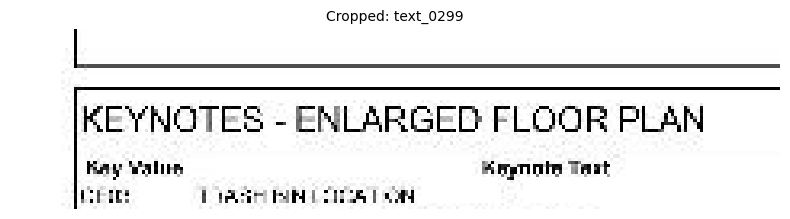

In [8]:
# Search for specific content - show CROPPED chunks instead of full pages
from construction_rag.visualization import crop_chunk_region
from construction_rag.models import Chunk, BoundingBox

queries = [
    "door schedule fire rating",
    "general notes",
    "project information",
    "floor plan layout"
]

for query in queries:
    print(f"\n{'='*50}")
    print(f"Query: '{query}'")
    print(f"{'='*50}")
    
    search_results = pipeline.query(query, n_results=3)
    
    if not search_results:
        print("  No results found.")
        continue
    
    # Show each result as a cropped chunk
    for i, r in enumerate(search_results, 1):
        source_image = r.metadata.get('source_image', '')
        print(f"\n  Result {i}: [{r.metadata['chunk_type']}] Score: {r.relevance_score:.3f}")
        
        if r.metadata.get('summary'):
            print(f"  Summary: {r.metadata['summary']}")
        else:
            print(f"  Content: {r.content[:150]}...")
        
        # Show cropped region of this chunk
        if source_image:
            image_path = f"sample_images/{os.path.basename(source_image)}"
            
            # Create a Chunk object for visualization
            chunk = Chunk(
                chunk_id=r.chunk_id,
                chunk_type=r.metadata.get('chunk_type', 'text'),
                content=r.content,
                bbox=BoundingBox(
                    r.metadata.get('bbox_x1', 0),
                    r.metadata.get('bbox_y1', 0),
                    r.metadata.get('bbox_x2', 1),
                    r.metadata.get('bbox_y2', 1)
                ),
                confidence=r.metadata.get('confidence', 0.9),
                metadata={'source_image': source_image},
                summary=r.metadata.get('summary')
            )
            
            # Crop and display the region
            try:
                cropped = crop_chunk_region(image_path, chunk, max_size=600, padding=20)
                fig, ax = plt.subplots(1, 1, figsize=(8, 4))
                ax.imshow(cropped)
                ax.set_title(f"Cropped: {r.chunk_id}", fontsize=10)
                ax.axis('off')
                plt.tight_layout()
                plt.show()
                plt.close(fig)
            except Exception as e:
                print(f"  (Could not display cropped region: {e})")

## 5. Question Answering with LLM

Use the `ask()` method to get LLM-generated answers grounded in the retrieved content. The visualization shows which parts of the drawings were used to answer each question (highlighted in yellow).


Q: What types of doors are mentioned in the drawings?

A: The drawings mention façade doors, which must have a minimum clear width of 32.3 inches.

--- Based on 5 context chunks: ---

  Context 1: [text] text_0300
  Summary: The document references a construction specification for a one-bedroom unit labeled A1004, with specific details found in section B2 and additional information in drawing SEE1/A318FCR.


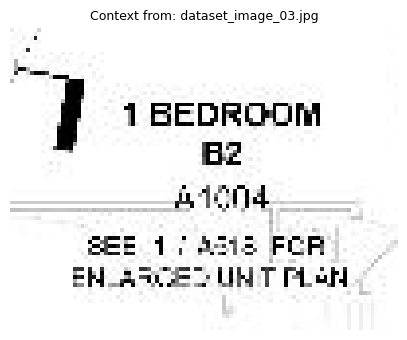


  Context 2: [text] text_0223
  Summary: All the façade doors must have a minimum clear width of 32.3 inches.


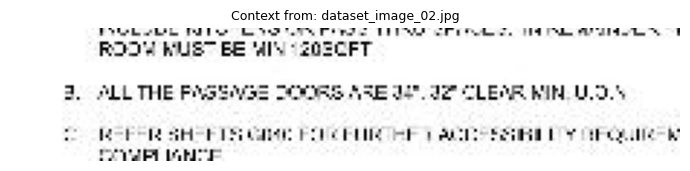


  Context 3: [text] text_0069
  Summary: The document outlines specifications for a two-bedroom construction project, identified as ENARGEDUNTRC-TWOSEDROOM-C(B9-10L), detailing key requirements for design, materials, and construction standards.


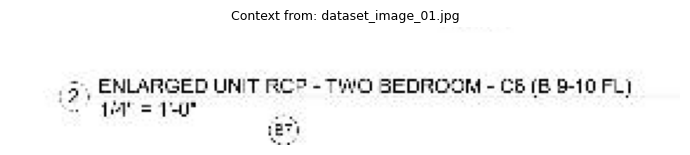


Q: What are the general construction notes?

A: The provided context does not contain specific details about the general construction notes. It only mentions that there are general notes in multiple instances, but does not elaborate on their content. Therefore, I cannot provide specific information regarding the general construction notes. 

Answer: Not found in the provided documents.

--- Based on 5 context chunks: ---

  Context 1: [text] text_0110
  Summary: GENERAL NOTES


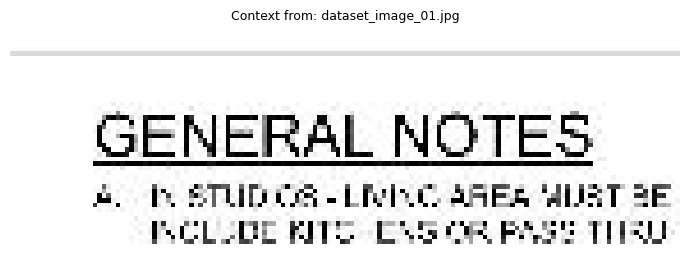


  Context 2: [text] text_0221
  Summary: GENERAL NOTES


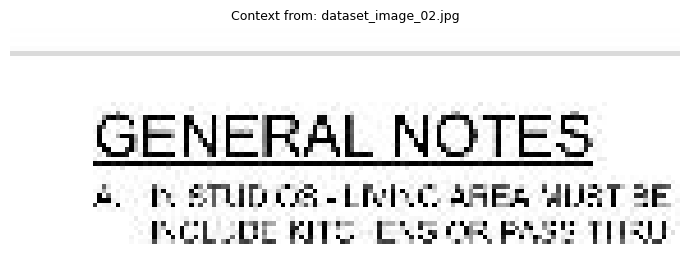


  Context 3: [text] text_0467
  Summary: GENERAL NOTES


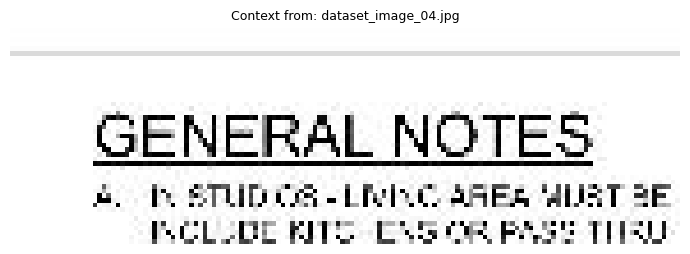


Q: What is the project name?

A: The project name is "STUDIOA1 A010."

--- Based on 5 context chunks: ---

  Context 1: [text] text_0292
  Summary: The document appears to be a construction specification for a project labeled "STUDIOA1 A010," detailing specific requirements and standards for the construction process. However, the text provided is incomplete and lacks clear information to summarize effectively.


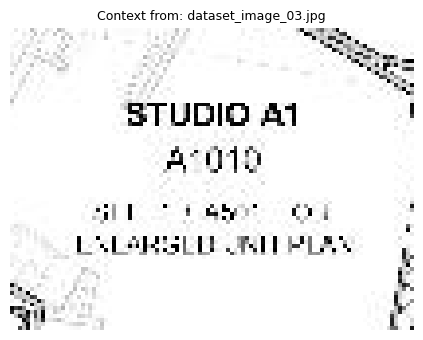


  Context 2: [title_block] title_block_0259
  Summary: The document outlines key project information, including specifications and requirements for the construction project, emphasizing essential details necessary for successful execution.


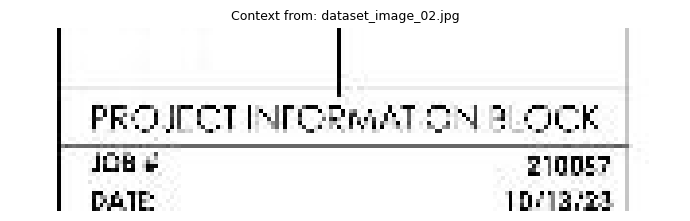


  Context 3: [title_block] title_block_0153
  Summary: The document outlines key project information and specifications for the construction project, including essential requirements and guidelines for execution. It serves as a comprehensive reference for stakeholders involved in the project.


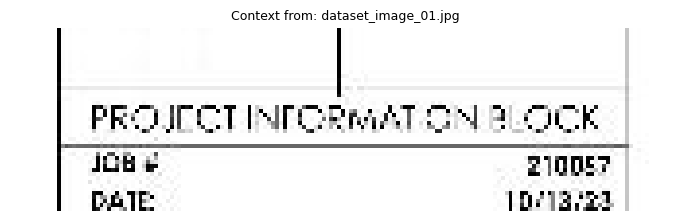

In [9]:
# Ask questions about the drawings - show cropped context chunks
questions = [
    "What types of doors are mentioned in the drawings?",
    "What are the general construction notes?",
    "What is the project name?"
]

for question in questions:
    print(f"\n{'='*60}")
    print(f"Q: {question}")
    print(f"{'='*60}")
    
    try:
        # Get answer with context chunks
        answer, context_chunks = pipeline.ask(question, return_context=True)
        print(f"\nA: {answer}")
        
        if context_chunks:
            print(f"\n--- Based on {len(context_chunks)} context chunks: ---")
            
            # Show each context chunk as a cropped image
            for i, chunk in enumerate(context_chunks[:3], 1):  # Limit to 3 chunks
                source_image = chunk.metadata.get('source_image', '')
                print(f"\n  Context {i}: [{chunk.chunk_type}] {chunk.chunk_id}")
                
                if chunk.summary:
                    print(f"  Summary: {chunk.summary}")
                else:
                    print(f"  Content: {chunk.content[:100]}...")
                
                # Show cropped region
                if source_image:
                    image_path = f"sample_images/{os.path.basename(source_image)}"
                    try:
                        cropped = crop_chunk_region(image_path, chunk, max_size=500, padding=15)
                        fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
                        ax.imshow(cropped)
                        ax.set_title(f"Context from: {source_image}", fontsize=9)
                        ax.axis('off')
                        plt.tight_layout()
                        plt.show()
                        plt.close(fig)
                    except Exception as e:
                        print(f"  (Could not display: {e})")
                
    except ValueError as e:
        print(f"\nError: {e}")
        print("(LLM not available - set OPENROUTER_API_KEY)")

## 6. Statistics

In [10]:
stats = pipeline.get_stats()

print("Final Statistics:")
print(f"  Total chunks indexed: {stats['total_chunks']}")
print(f"  Embedding model: {stats['embedding_model']}")
print(f"  Embedding dimension: {stats['embedding_dimension']}")
print(f"  LLM model: {stats.get('llm_model', 'None')}")
print(f"\n  Chunks by type:")
for chunk_type, count in stats['chunks_by_type'].items():
    print(f"    {chunk_type}: {count}")

Final Statistics:
  Total chunks indexed: 594
  Embedding model: all-MiniLM-L6-v2
  Embedding dimension: 384
  LLM model: openai/gpt-4o-mini

  Chunks by type:
    text: 408
    notes: 55
    title_block: 130
    viewport: 1


## 7. Clean Up

In [11]:
# Uncomment to clear the database
# pipeline.clear()
# print("Database cleared!")